# Notes:
1. Use **predicted spot price** to run linear programming algorithm.
2. **predicted spot price** is predicted using 48 step ahead method.
3. **predicted spot price** is predicted in two way:
   1. Predict with **known** demand
   2. Predict with **predicted** demand and known inter_gen
   3. Predict with **predicted** demand only
   

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from battery_optimise import *
from check import check_submission
from algo_utils import *

import warnings
warnings.filterwarnings("ignore")

plt.style.use('seaborn')
pd.set_option('display.float_format',lambda x : '%.2f' % x)

## 1) Load Data set and have a look at them

In [2]:
vic_cv_sarimax_48period = pd.read_csv('../modelling/predictions/vic_spot_price_cv_sarimax_48period.csv')
vic_test_sarimax_48period = pd.read_csv('../modelling/predictions/vic_spot_price_test_sarimax_48period.csv')

vic_cv_predicted_demand_48period = pd.read_csv('../modelling/predictions/vic_spot_price_cv_predicted_demand_48period.csv')
vic_test_predicted_demand_48period = pd.read_csv('../modelling/predictions/vic_spot_price_test_predicted_demand_48period.csv')

vic_cv_predicted_demand_unknow_48period = pd.read_csv('../modelling/predictions/vic_spot_price_cv_predicted_demand_unknow_48period.csv')
vic_test_predicted_demand_unknow_48period = pd.read_csv('../modelling/predictions/vic_spot_price_test_predicted_demand_unknow_48period.csv')

vic_cv_predicted_demand_unknow_48period.head(3)

,time,spot_price,predicted_spot_price
0,2021-01-01 00:00:00,43.48,47.93
1,2021-01-01 00:30:00,37.21,35.35
2,2021-01-01 01:00:00,36.37,17.56


In [3]:
vic_test_predicted_demand_48period

,time,spot_price,predicted_spot_price
0,2021-07-01 00:00:00,51.71,73.61
1,2021-07-01 00:30:00,90.51,67.61
2,2021-07-01 01:00:00,73.91,64.25
3,2021-07-01 01:30:00,33.79,62.37
4,2021-07-01 02:00:00,43.57,53.24
...,...,...,...
2011,2021-08-11 21:30:00,61.52,48.49
2012,2021-08-11 22:00:00,43.00,41.68
2013,2021-08-11 22:30:00,54.29,35.15
2014,2021-08-11 23:00:00,49.25,31.46


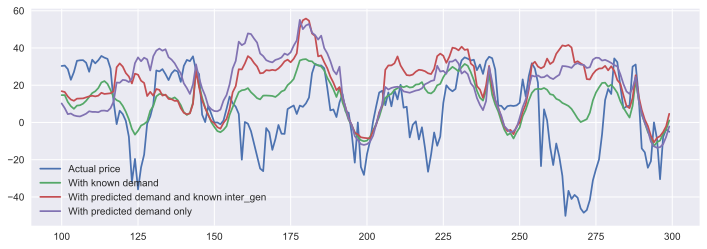

In [4]:
plt.figure(figsize=(12,4))
start = 100
end = 300
plt.plot(vic_cv_sarimax_48period.spot_price[start:end], label='Actual price')
plt.plot(vic_cv_sarimax_48period.predicted_spot_price[start:end], label='With known demand')
plt.plot(vic_cv_predicted_demand_48period.predicted_spot_price[start:end], label='With predicted demand and known inter_gen')
plt.plot(vic_cv_predicted_demand_unknow_48period.predicted_spot_price[start:end], label='With predicted demand only')
plt.legend()
plt.show()

## 2) Run pyomo simulation

### 2.1) Define simulation function

In [5]:
def simulate_optimisation(datetime, spot_price, solver='glpk'):
    assert len(datetime) == len(spot_price)
    df = pd.DataFrame({'datetime': datetime, 'predicted_spot_price': spot_price}).reset_index(drop=True)
    start = 0
    one_day = 48
    n = int(len(df)/one_day)
    df['predicted_power'] = 0
    df['predicted_dispatch'] = 0
    df['predicted_capacity'] = np.nan
    for i in range(n):

        # here we must get the initial capacity of day t+1
        if i == 0:
            initial_capacity = 0
        else:
            initial_capacity = np.where(df.predicted_power[start-1] < 0,
                                        df.predicted_capacity[start-1] - df.predicted_power[start-1]/2*0.9,
                                        df.predicted_capacity[start-1] - df.predicted_power[start-1]/2)
            initial_capacity = float(initial_capacity)

        predicted_spot_price = df.predicted_spot_price[start:start+one_day]
        datetime = df.datetime[start:start+one_day]
        result = battery_optimisation(datetime, predicted_spot_price, initial_capacity=initial_capacity, solver=solver)
        df.predicted_power[start:start+one_day] = result.power
        df.predicted_dispatch[start:start+one_day] = result.market_dispatch
        df.predicted_capacity[start:start+one_day] = result.opening_capacity
        start += one_day
    return df

### 2.1) Run CV period

#### 2.1.1) CV period - Mandatory revenue (perfect foresight)

In [6]:
# Mandatory revenue (perfect foresight)
spot_price = vic_cv_sarimax_48period.spot_price
datetime = vic_cv_sarimax_48period.time

df_cv_observed_dispatch = battery_optimisation(datetime, spot_price)
df_cv_check_observed = df_cv_observed_dispatch[['datetime', 'power', 'opening_capacity']]
df_cv_check_observed.columns = ['datetime', 'power', 'capacity']
result_cv_observed = check_submission(df_cv_check_observed, spot_prices=spot_price, include_capacity=True, include_revenue=True)

print('===== Perfect Foresight =====')
print(result_cv_observed.groupby('flag').count())
print('Observed Revenue:', result_cv_observed.revenue.sum().round())

===== Perfect Foresight =====
      datetime  capacity  revenue
flag                             
0         8688      8688     8688
Observed Revenue: 17664385.0


#### 2.1.2) CV period - Bonus revenue (with price predicted using **known** demand)

In [7]:
# Bonus revenue (predicted price with known demand)
predicted_spot_price = vic_cv_sarimax_48period.predicted_spot_price
spot_price = vic_cv_sarimax_48period.spot_price
datetime = vic_cv_sarimax_48period.time

df_cv_predicted_dispatch_1 = simulate_optimisation(datetime, predicted_spot_price)
df_cv_check_predicted_1 = df_cv_predicted_dispatch_1[['datetime', 'predicted_power', 'predicted_capacity']]
df_cv_check_predicted_1.columns = ['datetime', 'power', 'capacity']
result_cv_predicted_1 = check_submission(df_cv_check_predicted_1, spot_prices=spot_price, include_capacity=True, include_revenue=True)

print('===== Bonus 1 =====')
print(result_cv_predicted_1.groupby('flag').count())
print('Predicted Revenue:', result_cv_predicted_1.revenue.sum().round())
# Add spot price prediction
submission_cv_predicted_1 = df_cv_check_predicted_1.copy(deep=False)
submission_cv_predicted_1['spot_price_prediction'] = predicted_spot_price

===== Bonus 1 =====
      datetime  capacity  revenue
flag                             
0         8688      8688     8688
Predicted Revenue: 11164550.0


#### 2.1.3) CV period - Bonus revenue (with price predicted using **predicted** demand and true inter_gen)

In [8]:
# Observed revenue (predicted price with predicted demand and true inter_gen)
predicted_spot_price = vic_cv_predicted_demand_48period.predicted_spot_price
spot_price = vic_cv_predicted_demand_48period.spot_price
datetime = vic_cv_predicted_demand_48period.time

df_cv_predicted_dispatch_2 = battery_optimisation(datetime, predicted_spot_price)
df_cv_check_predicted_2 = df_cv_predicted_dispatch_2[['datetime', 'power', 'opening_capacity']]
df_cv_check_predicted_2.columns = ['datetime', 'power', 'capacity']
result_cv_predicted_2 = check_submission(df_cv_check_predicted_2, spot_prices=spot_price, include_capacity=True, include_revenue=True)

print('===== Bonus 2 =====')
print(result_cv_predicted_2.groupby('flag').count())
print('Observed Revenue:', result_cv_predicted_2.revenue.sum().round())
# Add spot price prediction
submission_cv_predicted_2 = df_cv_check_predicted_2.copy(deep=False)
submission_cv_predicted_2['spot_price_prediction'] = predicted_spot_price

===== Bonus 2 =====
      datetime  capacity  revenue
flag                             
0         8688      8688     8688
Observed Revenue: 9623296.0


#### 2.1.4) CV period - Bonus revenue (with price predicted using **predicted** demand only)

In [9]:
# Observed revenue (predicted price with predicted demand only)
predicted_spot_price = vic_cv_predicted_demand_unknow_48period.predicted_spot_price
spot_price = vic_cv_predicted_demand_unknow_48period.spot_price
datetime = vic_cv_predicted_demand_unknow_48period.time

df_cv_predicted_dispatch_3 = battery_optimisation(datetime, predicted_spot_price)
df_cv_check_predicted_3 = df_cv_predicted_dispatch_3[['datetime', 'power', 'opening_capacity']]
df_cv_check_predicted_3.columns = ['datetime', 'power', 'capacity']
result_cv_predicted_3 = check_submission(df_cv_check_predicted_3, spot_prices=spot_price, include_capacity=True, include_revenue=True)

print('===== Bonus 3 =====')
print(result_cv_predicted_3.groupby('flag').count())
print('Observed Revenue:', result_cv_predicted_3.revenue.sum().round())
# Add spot price prediction
submission_cv_predicted_3 = df_cv_check_predicted_3.copy(deep=False)
submission_cv_predicted_3['spot_price_prediction'] = predicted_spot_price

===== Bonus 3 =====
      datetime  capacity  revenue
flag                             
0         8688      8688     8688
Observed Revenue: 9038962.0


#### 2.1.5) Save result as csv file

In [10]:
# Save predicted result to csv
submission_cv_predicted_1.to_csv('../../results/result_cv_predicted_1.csv', index=False)
submission_cv_predicted_2.to_csv('../../results/result_cv_predicted_2.csv', index=False)
submission_cv_predicted_3.to_csv('../../results/result_cv_predicted_3.csv', index=False)

### 2.2) Run Test period

#### 2.2.1) Test period - Mandatory revenue (perfect foresight)

In [11]:
# Bonus revenue (predicted price with predicted demand)
spot_price = vic_test_sarimax_48period.spot_price
datetime = vic_test_sarimax_48period.time

df_test_observed_dispatch = battery_optimisation(datetime, spot_price)
df_test_check_observed = df_test_observed_dispatch[['datetime', 'power', 'opening_capacity']]
df_test_check_observed.columns = ['datetime', 'power', 'capacity']
result_test_observed = check_submission(df_test_check_observed, spot_prices=spot_price, include_capacity=True, include_revenue=True)

print('===== Perfect Foresight =====')
print(result_test_observed.groupby('flag').count())
print('Observed Revenue:', result_test_observed.revenue.sum().round())

===== Perfect Foresight =====
      datetime  capacity  revenue
flag                             
0         2016      2016     2016
Observed Revenue: 5827083.0


#### 2.2.2) Test period - Bonus revenue (with price predicted using **known** demand)

In [12]:
# Predicted revenue (apply prediction action to observed price)
predicted_spot_price = vic_test_sarimax_48period.predicted_spot_price
spot_price = vic_test_sarimax_48period.spot_price
datetime = vic_test_sarimax_48period.time

df_test_predicted_dispatch_1 = simulate_optimisation(datetime, predicted_spot_price)
df_test_check_predicted_1 = df_test_predicted_dispatch_1[['datetime', 'predicted_power', 'predicted_capacity']]
df_test_check_predicted_1.columns = ['datetime', 'power', 'capacity']
result_test_predicted_1 = check_submission(df_test_check_predicted_1, spot_prices=spot_price, include_capacity=True, include_revenue=True)

print('===== Bonus 1 =====')
print(result_test_predicted_1.groupby('flag').count())
print('Predicted Revenue:', result_test_predicted_1.revenue.sum().round())
# Add spot price prediction
submission_test_predicted_1 = df_test_check_predicted_1.copy(deep=False)
submission_test_predicted_1['spot_price_prediction'] = predicted_spot_price

===== Bonus 1 =====
      datetime  capacity  revenue
flag                             
0         2016      2016     2016
Predicted Revenue: 4062733.0


#### 2.2.3) Test period - Bonus revenue (with price predicted using **predicted** demand and true inter_gen) 

In [13]:
# Observed revenue (predicted price with predicted demand and inter_gen)
predicted_spot_price = vic_test_predicted_demand_48period.predicted_spot_price
spot_price = vic_test_predicted_demand_48period.spot_price
datetime = vic_test_predicted_demand_48period.time

df_test_predicted_dispatch_2 = simulate_optimisation(datetime, predicted_spot_price)
df_test_check_predicted_2 = df_test_predicted_dispatch_2[['datetime', 'predicted_power', 'predicted_capacity']]
df_test_check_predicted_2.columns = ['datetime', 'power', 'capacity']
result_test_predicted_2 = check_submission(df_test_check_predicted_2, spot_prices=spot_price, include_capacity=True, include_revenue=True)

print('===== Bonus 2 =====')
print(result_test_predicted_2.groupby('flag').count())
print('Observed Revenue:', result_test_predicted_2.revenue.sum().round())
# Add spot price prediction
submission_test_predicted_2 = df_test_check_predicted_2.copy(deep=False)
submission_test_predicted_2['spot_price_prediction'] = predicted_spot_price

===== Bonus 2 =====
      datetime  capacity  revenue
flag                             
0         2016      2016     2016
Observed Revenue: 3783430.0


#### 2.2.4) Test period - Bonus revenue (with price predicted using **predicted** demand only)

In [14]:
# Observed revenue (predicted price with predicted demand only)
predicted_spot_price = vic_test_predicted_demand_unknow_48period.predicted_spot_price
spot_price = vic_test_predicted_demand_unknow_48period.spot_price
datetime = vic_test_predicted_demand_unknow_48period.time

df_test_predicted_dispatch_3 = simulate_optimisation(datetime, predicted_spot_price)
df_test_check_predicted_3 = df_test_predicted_dispatch_3[['datetime', 'predicted_power', 'predicted_capacity']]
df_test_check_predicted_3.columns = ['datetime', 'power', 'capacity']
result_test_predicted_3 = check_submission(df_test_check_predicted_3, spot_prices=spot_price, include_capacity=True, include_revenue=True)

print('===== Bonus 3 =====')
print(result_test_predicted_3.groupby('flag').count())
print('Observed Revenue:', result_test_predicted_3.revenue.sum().round())
# Add spot price prediction
submission_test_predicted_3 = df_test_check_predicted_3.copy(deep=False)
submission_test_predicted_3['spot_price_prediction'] = predicted_spot_price

===== Bonus 3 =====
      datetime  capacity  revenue
flag                             
0         2016      2016     2016
Observed Revenue: 3700203.0


#### 2.2.5) Save result as csv file

In [15]:
# Save predicted result to csv
submission_test_predicted_1.to_csv('../../results/result_test_predicted_1.csv', index=False)
submission_test_predicted_2.to_csv('../../results/result_test_predicted_2.csv', index=False)
submission_test_predicted_3.to_csv('../../results/result_test_predicted_3.csv', index=False)

### 2.3) EXTRA: Use predict price to predict revenue (Expected Revenue)

### 2.3.1) Bonus 1 - Expected Revenue

In [16]:
# Bonus revenue (predicted price with known demand)
predicted_spot_price = vic_cv_sarimax_48period.predicted_spot_price
spot_price = vic_cv_sarimax_48period.spot_price
datetime = vic_cv_sarimax_48period.time

df_cv_predicted_dispatch_1r = simulate_optimisation(datetime, predicted_spot_price)
df_cv_check_predicted_1r = df_cv_predicted_dispatch_1r[['datetime', 'predicted_power', 'predicted_capacity']]
df_cv_check_predicted_1r.columns = ['datetime', 'power', 'capacity']
result_cv_predicted_1r = check_submission(df_cv_check_predicted_1r, spot_prices=predicted_spot_price, include_capacity=True, include_revenue=True)

print('===== Bonus 1 CV Period (Expected revenue) =====')
print(result_cv_predicted_1r.groupby('flag').count())
print('Predicted Revenue:', result_cv_predicted_1r.revenue.sum().round(), '\n')

# Predicted revenue (apply prediction action to observed price)
predicted_spot_price = vic_test_sarimax_48period.predicted_spot_price
spot_price = vic_test_sarimax_48period.spot_price
datetime = vic_test_sarimax_48period.time

df_test_predicted_dispatch_1r = simulate_optimisation(datetime, predicted_spot_price)
df_test_check_predicted_1r = df_test_predicted_dispatch_1r[['datetime', 'predicted_power', 'predicted_capacity']]
df_test_check_predicted_1r.columns = ['datetime', 'power', 'capacity']
result_test_predicted_1r = check_submission(df_test_check_predicted_1r, spot_prices=predicted_spot_price, include_capacity=True, include_revenue=True)

print('===== Bonus 1 Test Period (Expected revenue) =====')
print(result_test_predicted_1r.groupby('flag').count())
print('Predicted Revenue:', result_test_predicted_1r.revenue.sum().round())

===== Bonus 1 CV Period (Expected revenue) =====
      datetime  capacity  revenue
flag                             
0         8688      8688     8688
Predicted Revenue: 6131623.0 

===== Bonus 1 Test Period (Expected revenue) =====
      datetime  capacity  revenue
flag                             
0         2016      2016     2016
Predicted Revenue: 1765914.0


### 2.3.2) Bonus 2 - Expected Revenue

In [17]:
# Observed revenue (predicted price with predicted demand and true inter_gen)
predicted_spot_price = vic_cv_predicted_demand_48period.predicted_spot_price
spot_price = vic_cv_predicted_demand_48period.spot_price
datetime = vic_cv_predicted_demand_48period.time

df_cv_predicted_dispatch_2r = battery_optimisation(datetime, predicted_spot_price)
df_cv_check_predicted_2r = df_cv_predicted_dispatch_2r[['datetime', 'power', 'opening_capacity']]
df_cv_check_predicted_2r.columns = ['datetime', 'power', 'capacity']
result_cv_predicted_2r = check_submission(df_cv_check_predicted_2, spot_prices=predicted_spot_price, include_capacity=True, include_revenue=True)

print('===== Bonus 2 CV Period (Expected revenue) =====')
print(result_cv_predicted_2r.groupby('flag').count())
print('Observed Revenue:', result_cv_predicted_2r.revenue.sum().round(), '\n')


# Observed revenue (predicted price with predicted demand and true inter_gen)
predicted_spot_price = vic_test_predicted_demand_48period.predicted_spot_price
spot_price = vic_test_predicted_demand_48period.spot_price
datetime = vic_test_predicted_demand_48period.time

df_test_predicted_dispatch_2r = simulate_optimisation(datetime, predicted_spot_price)
df_test_check_predicted_2r = df_test_predicted_dispatch_2r[['datetime', 'predicted_power', 'predicted_capacity']]
df_test_check_predicted_2r.columns = ['datetime', 'power', 'capacity']
result_test_predicted_2r = check_submission(df_test_check_predicted_2r, spot_prices=predicted_spot_price, include_capacity=True, include_revenue=True)

print('===== Bonus 2 Test Period (Expected revenue)=====')
print(result_test_predicted_2r.groupby('flag').count())
print('Observed Revenue:', result_test_predicted_2r.revenue.sum().round())

===== Bonus 2 CV Period (Expected revenue) =====
      datetime  capacity  revenue
flag                             
0         8688      8688     8688
Observed Revenue: 5655915.0 

===== Bonus 2 Test Period (Expected revenue)=====
      datetime  capacity  revenue
flag                             
0         2016      2016     2016
Observed Revenue: 1673235.0


### 2.3.3) Bonus 3 - Expected Revenue

In [18]:
# Observed revenue (predicted price with predicted demand only)
predicted_spot_price = vic_cv_predicted_demand_unknow_48period.predicted_spot_price
spot_price = vic_cv_predicted_demand_unknow_48period.spot_price
datetime = vic_cv_predicted_demand_unknow_48period.time

df_cv_predicted_dispatch_3r = battery_optimisation(datetime, predicted_spot_price)
df_cv_check_predicted_3r = df_cv_predicted_dispatch_3r[['datetime', 'power', 'opening_capacity']]
df_cv_check_predicted_3r.columns = ['datetime', 'power', 'capacity']
result_cv_predicted_3r = check_submission(df_cv_check_predicted_3, spot_prices=predicted_spot_price, include_capacity=True, include_revenue=True)

print('===== Bonus 3 CV Period (Expected revenue) =====')
print(result_cv_predicted_3r.groupby('flag').count())
print('Observed Revenue:', result_cv_predicted_3r.revenue.sum().round(), '\n')


# Observed revenue (predicted price with predicted demand only)
predicted_spot_price = vic_test_predicted_demand_unknow_48period.predicted_spot_price
spot_price = vic_test_predicted_demand_unknow_48period.spot_price
datetime = vic_test_predicted_demand_unknow_48period.time

df_test_predicted_dispatch_3r = simulate_optimisation(datetime, predicted_spot_price)
df_test_check_predicted_3r = df_test_predicted_dispatch_3r[['datetime', 'predicted_power', 'predicted_capacity']]
df_test_check_predicted_3r.columns = ['datetime', 'power', 'capacity']
result_test_predicted_3r = check_submission(df_test_check_predicted_3r, spot_prices=predicted_spot_price, include_capacity=True, include_revenue=True)

print('===== Bonus 3 Test Period (Expected revenue)=====')
print(result_test_predicted_3r.groupby('flag').count())
print('Observed Revenue:', result_test_predicted_3r.revenue.sum().round())

===== Bonus 3 CV Period (Expected revenue) =====
      datetime  capacity  revenue
flag                             
0         8688      8688     8688
Observed Revenue: 5875058.0 

===== Bonus 3 Test Period (Expected revenue)=====
      datetime  capacity  revenue
flag                             
0         2016      2016     2016
Observed Revenue: 1540807.0


## 3) Evaluation

### 3.1) Plot Cumulative Revenue

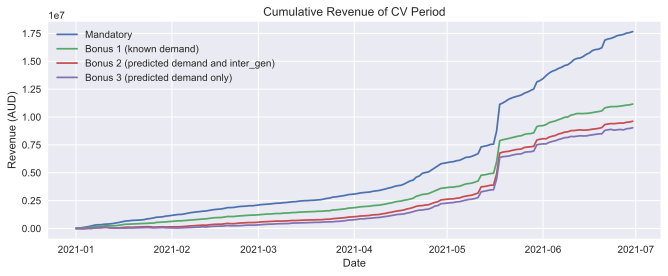

In [19]:
result_cv_observed['date'] = result_cv_observed.datetime.astype('datetime64[ns]').dt.date
result_cv_predicted_1['date'] = result_cv_predicted_1.datetime.astype('datetime64[ns]').dt.date
result_cv_predicted_2['date'] = result_cv_predicted_2.datetime.astype('datetime64[ns]').dt.date
result_cv_predicted_3['date'] = result_cv_predicted_3.datetime.astype('datetime64[ns]').dt.date

plt.figure(figsize=(11, 4))
plt.plot(result_cv_observed.groupby('date').revenue.sum().cumsum(), label='Mandatory')
plt.plot(result_cv_predicted_1.groupby('date').revenue.sum().cumsum(), label='Bonus 1 (known demand)')
plt.plot(result_cv_predicted_2.groupby('date').revenue.sum().cumsum(), label='Bonus 2 (predicted demand and inter_gen)')
plt.plot(result_cv_predicted_3.groupby('date').revenue.sum().cumsum(), label='Bonus 3 (predicted demand only)')

plt.title('Cumulative Revenue of CV Period')
plt.ylabel('Revenue (AUD)')
plt.xlabel('Date')
plt.legend()
plt.show()

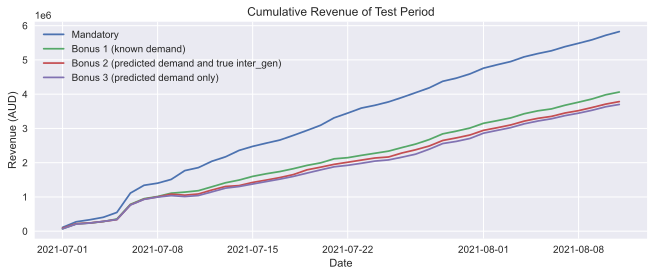

In [20]:
result_test_observed['date'] = result_test_observed.datetime.astype('datetime64[ns]').dt.date
result_test_predicted_1['date'] = result_test_predicted_1.datetime.astype('datetime64[ns]').dt.date
result_test_predicted_2['date'] = result_test_predicted_2.datetime.astype('datetime64[ns]').dt.date
result_test_predicted_3['date'] = result_test_predicted_3.datetime.astype('datetime64[ns]').dt.date

plt.figure(figsize=(11, 4))
plt.plot(result_test_observed.groupby('date').revenue.sum().cumsum(), label='Mandatory')
plt.plot(result_test_predicted_1.groupby('date').revenue.sum().cumsum(), label='Bonus 1 (known demand)')
plt.plot(result_test_predicted_2.groupby('date').revenue.sum().cumsum(), label='Bonus 2 (predicted demand and true inter_gen)')
plt.plot(result_test_predicted_3.groupby('date').revenue.sum().cumsum(), label='Bonus 3 (predicted demand only)')

plt.title('Cumulative Revenue of Test Period')
plt.ylabel('Revenue (AUD)')
plt.xlabel('Date')
plt.legend()
plt.show()

### 3.2) Plot Actions (Bonus 1 & Bonus 2)

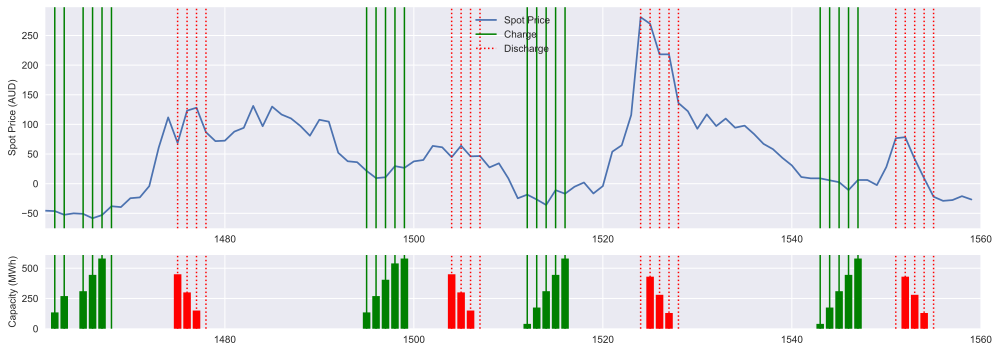

In [21]:
# Bonus 1 (with price predicted using known demand)
start = df_test_check_predicted_1[df_test_check_predicted_1.datetime == '2021-07-31 10:30:00'].index[0]
end = df_test_check_predicted_1[df_test_check_predicted_1.datetime == '2021-08-02 12:00:00'].index[0]
closing_capacity = df_test_check_predicted_1.capacity.shift(-1)[start:end+1]
power = df_test_check_predicted_1.power[start:end+1]
spot_price = vic_test_sarimax_48period.spot_price[start:end+1]
plot_actions(spot_price, power, closing_capacity=closing_capacity)

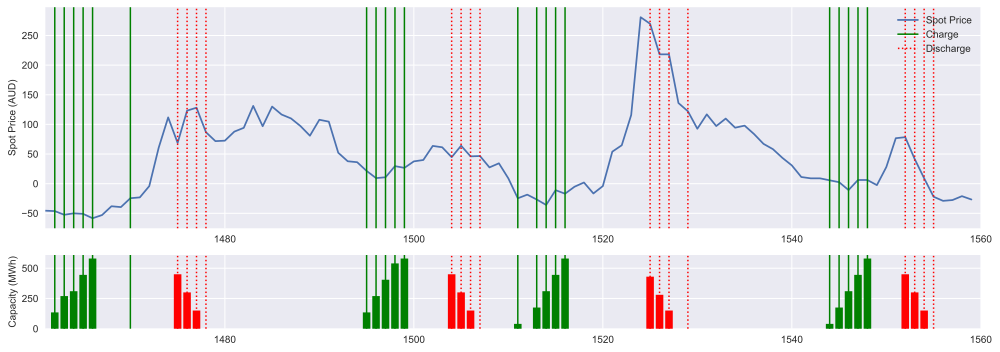

In [22]:
# Bonus 2 (with price predicted using predicted demand and true inter_gen)
start = df_test_check_predicted_2[df_test_check_predicted_2.datetime == '2021-07-31 10:30:00'].index[0]
end = df_test_check_predicted_2[df_test_check_predicted_2.datetime == '2021-08-02 12:00:00'].index[0]
closing_capacity = df_test_check_predicted_2.capacity.shift(-1)[start:end+1]
power = df_test_check_predicted_2.power[start:end+1]
spot_price = vic_test_sarimax_48period.spot_price[start:end+1]
plot_actions(spot_price, power, closing_capacity=closing_capacity)

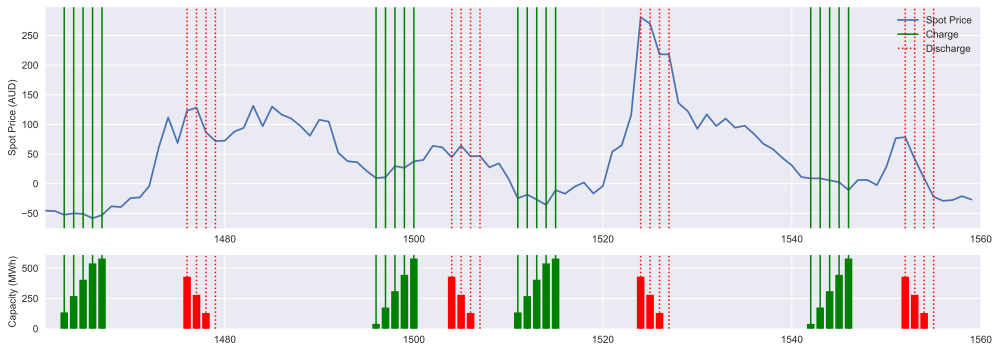

In [23]:
# Bonus 3 (with price predicted using predicted demand only)
start = df_test_check_predicted_3[df_test_check_predicted_3.datetime == '2021-07-31 10:30:00'].index[0]
end = df_test_check_predicted_3[df_test_check_predicted_3.datetime == '2021-08-02 12:00:00'].index[0]
closing_capacity = df_test_check_predicted_3.capacity.shift(-1)[start:end+1]
power = df_test_check_predicted_3.power[start:end+1]
spot_price = vic_test_sarimax_48period.spot_price[start:end+1]
plot_actions(spot_price, power, closing_capacity=closing_capacity)